# Training Mixture of Experts on two disjoint datasets

Notebook to train and analyze a Mixture of Experts architecture using data split on the default mnist dataset (*mnist_model*) and an additional mnist-like dataset with hand-written numbers from switzerland (*swiss_model*). Default MNIST dataset is downsampled to match the number of samples in the swiss MNIST dataset. Training data (13,594 samples), validation data (1,699 samples) and test data (1,700 samples) are equally sized and merged into one set for training, validation and testing the gating network. 

Two experts (*mnist_model* and *swiss_model*) are trained separately, one on each dataset. The trained models are saved under *'./trained_models/dataset_split/swiss_model.pth'* and *'./trained_models/dataset_split/mnist_model.pth'*, respectively. 

In a second step a gating network (*gate*) is trained on the combined datasets from default mnist and swiss mnist data. The trained model is saved under *'./trained_models/gate_model.pth'*.

In [1]:
import torch
import torchvision
import numpy as np
from models.mnist.mnist_net import MnistNet
from models.mnist.gating_network import GatingNetwork
from datasets.mnist_dataset import MNISTDataset
from utils.plot_confusion_matrix import plot_confusion_matrix
from utils.dataset_utils import train_test_split, build_subset, get_transformation

In [2]:
transformations_mnist_default = torchvision.transforms.Compose([
                torchvision.transforms.Resize((28,28)),
                torchvision.transforms.Grayscale(),
                torchvision.transforms.ToTensor(),
])

transformations_mnist_swiss = torchvision.transforms.Compose([
                torchvision.transforms.Resize((28,28)),
                torchvision.transforms.Grayscale(),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Lambda(lambda x: 1 - x)
])

In [ ]:
transformations_mnist_default = get_transformation('mnist')
transformations_mnist_swiss = get_transformation('swiss_mnist')

In [3]:
torch.manual_seed(42)

device = "cuda:0" if torch.cuda.is_available() else "cpu:0"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [4]:
# Load datasets
mnist_default_train = MNISTDataset('../../data/default_mnist/training', transform=transformations_mnist_default)
mnist_default_test = MNISTDataset('../../data/default_mnist/testing', transform=transformations_mnist_default)

mnist_swiss_train = MNISTDataset('../../data/swiss_mnist/training', transform=transformations_mnist_swiss)
mnist_swiss_test = MNISTDataset('../../data/swiss_mnist/testing', transform=transformations_mnist_swiss)

# Subsample default MNIST
mnist_default_train, _ = train_test_split(mnist_default_train, proportions=[len(mnist_swiss_train) / len(mnist_default_train), 0])
mnist_default_train, mnist_default_valid = train_test_split(mnist_default_train, [0.8, 0.2])
mnist_default_test, _ = train_test_split(mnist_default_test, proportions=[len(mnist_swiss_test) / len(mnist_default_test), 0])

mnist_swiss_train, mnist_swiss_valid = train_test_split(mnist_swiss_train, [0.8, 0.2])

# Combine datasets
combined_train = torch.utils.data.ConcatDataset([mnist_swiss_train, mnist_default_train])
combined_valid = torch.utils.data.ConcatDataset([mnist_swiss_valid, mnist_default_valid])
combined_test = torch.utils.data.ConcatDataset([mnist_swiss_test, mnist_default_test])


In [12]:
print('swiss_training_data: ', len(mnist_swiss_train))
print('swiss_validation_data: ', len(mnist_swiss_valid))
print('swiss_test_data: ', len(mnist_swiss_test))
print()

print('mnist_training_data: ', len(mnist_default_train))
print('mnist_validation_data: ', len(mnist_default_valid))
print('mnist_test_data: ', len(mnist_default_test))
print()

print('combined_training_data: ', len(combined_train))
print('combined_valid_data:', len(combined_valid))
print('combined_test_data: ', len(combined_test))

swiss_training_data:  11244
swiss_validation_data:  2812
swiss_test_data:  2337

mnist_training_data:  11244
mnist_validation_data:  2812
mnist_test_data:  2337

combined_training_data:  22488
combined_valid_data: 5624
combined_test_data:  4674


In [13]:
swiss_model = MnistNet(classes=[i for i in range(10)], name='swiss_expert')
#swiss_model.load_state_dict(torch.load('./trained_models/dataset_split/swiss_model.pth'))
swiss_model.fit(
    training_data=mnist_swiss_train,
    validation_data=mnist_swiss_valid,
    num_epochs=25,
    batch_size=256,
    criterion=criterion,
    learning_rate=0.001,
    save_state_path='./trained_models/dataset_split/swiss_model.pth',
    return_best_model=True,
    enable_logging=False
)

mnist_model = MnistNet(classes=[i for i in range(10)], name='mnist_expert')
#mnist_model.load_state_dict(torch.load('./trained_models/dataset_split/mnist_model.pth'))
mnist_model.fit(
    training_data=mnist_default_train,
    validation_data=mnist_default_valid,
    num_epochs=25,
    batch_size=256,
    criterion=criterion,
    learning_rate=0.001,
    save_state_path='./trained_models/dataset_split/mnist_model.pth',
    return_best_model=True,
    enable_logging=False
)

------------------------------------ Beginning Training ------------------------------------
Training of  swiss_expert
Training on device:  cuda:0
Training on 11,244 samples
Validation on 2,812 samples
Trainable parameters 421,642:
Total parameters 421,642:
Epoch 1/25
----------
training Loss: 2.0000  Accuracy: 0.1922
validation Loss: 1.0000  Accuracy: 0.4214

Epoch 2/25
----------
training Loss: 1.0000  Accuracy: 0.4238
validation Loss: 1.0000  Accuracy: 0.5658

Epoch 3/25
----------
training Loss: 1.0000  Accuracy: 0.5485
validation Loss: 1.0000  Accuracy: 0.6888

Epoch 4/25
----------
training Loss: 1.0000  Accuracy: 0.6673
validation Loss: 0.0000  Accuracy: 0.8062

Epoch 5/25
----------
training Loss: 0.0000  Accuracy: 0.7485
validation Loss: 0.0000  Accuracy: 0.8535

Epoch 6/25
----------
training Loss: 0.0000  Accuracy: 0.7967
validation Loss: 0.0000  Accuracy: 0.8748

Epoch 7/25
----------
training Loss: 0.0000  Accuracy: 0.8260
validation Loss: 0.0000  Accuracy: 0.8908

Epoch 8

In [14]:
gate = GatingNetwork(
    classes=[i for i in range(10)], 
    experts=[swiss_model, mnist_model],
    name='Gate')

In [15]:
print('Expert performance on mnist testset: ', gate.evaluate_experts(mnist_default_test, 256, criterion))
print('Expert performance on swiss testset: ', gate.evaluate_experts(mnist_swiss_test, 256, criterion))
print('Expert performance on gate testset: ', gate.evaluate_experts(combined_test, 256, criterion))

------------------------------------ Beginning Evaluation ------------------------------------
Training of  swiss_expert
Training on device:  cuda:0
Training on 2,337 samples
Evaluation complete in  00:00:00
Evaluation Accuracy: 0.7467
------------------------------------ Finished Evaluation ------------------------------------

------------------------------------ Beginning Evaluation ------------------------------------
Training of  mnist_expert
Training on device:  cuda:0
Training on 2,337 samples
Evaluation complete in  00:00:00
Evaluation Accuracy: 0.9863
------------------------------------ Finished Evaluation ------------------------------------

Expert performance on mnist testset:  [{'loss': tensor(2), 'aux_loss': tensor(0), 'acc': 0.7466837826273, 'examples_cof': tensor(0), 'importance_cof': tensor(0)}, {'loss': tensor(0), 'aux_loss': tensor(0), 'acc': 0.9863072314933675, 'examples_cof': tensor(0), 'importance_cof': tensor(0)}]
------------------------------------ Beginning E

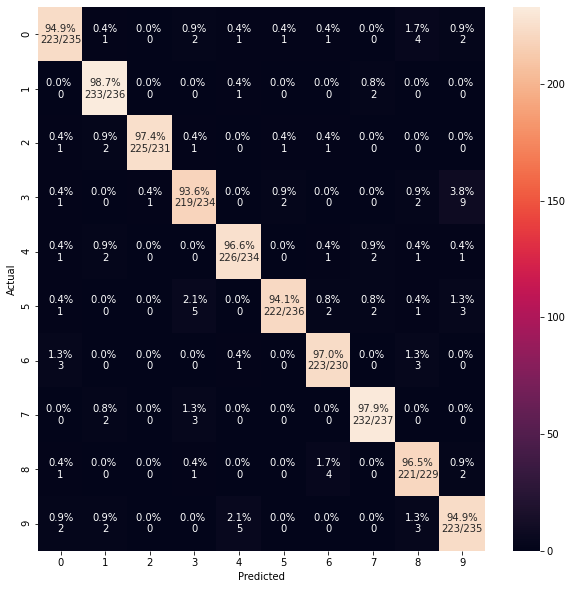

In [16]:
# confusion matrix of swiss expert for swiss mnist testset
y_pred = swiss_model.predict(mnist_swiss_test)
y_true = [int(x) for x in np.array(mnist_swiss_test.targets)]
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])

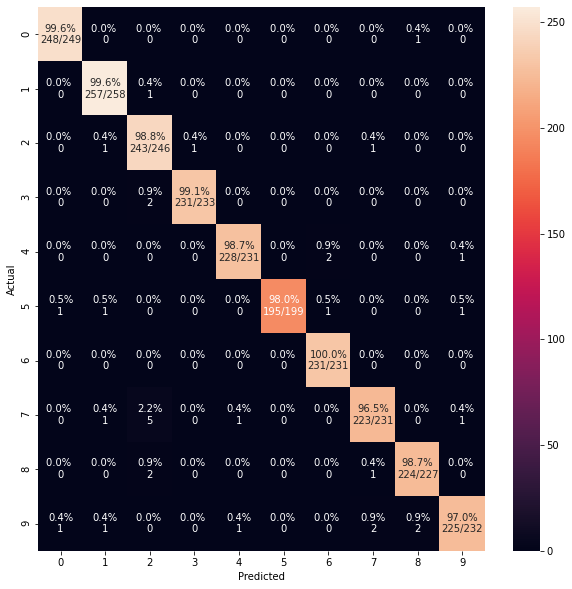

In [17]:
# confusion matrix of default expert for default mnist testset
y_pred = mnist_model.predict(mnist_default_test)
y_true = [int(x) for x in np.array(mnist_default_test.targets)]
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])

In [19]:
print('Gate performance on mnist testset: ', gate.evaluate(mnist_default_test, 32, criterion))
print('Gate performance on swiss testset: ', gate.evaluate(mnist_swiss_test, 32, criterion))
print('Gate performance on gate testset: ', gate.evaluate(combined_test, 32, criterion))

------------------------------------ Beginning Evaluation ------------------------------------
Training of  Gate
Training on device:  cuda:0
Training on 2,337 samples
Evaluation complete in  00:00:00
Evaluation Accuracy: 0.8605
------------------------------------ Finished Evaluation ------------------------------------

Gate performance on mnist testset:  {'loss': tensor(0), 'aux_loss': tensor(0), 'acc': 0.860504920838682, 'examples_cof': tensor(0), 'importance_cof': tensor(0)}
------------------------------------ Beginning Evaluation ------------------------------------
Training of  Gate
Training on device:  cuda:0
Training on 2,337 samples
Evaluation complete in  00:00:00
Evaluation Accuracy: 0.9414
------------------------------------ Finished Evaluation ------------------------------------

Gate performance on swiss testset:  {'loss': tensor(0), 'aux_loss': tensor(0), 'acc': 0.9413778348309799, 'examples_cof': tensor(0), 'importance_cof': tensor(0)}
-------------------------------

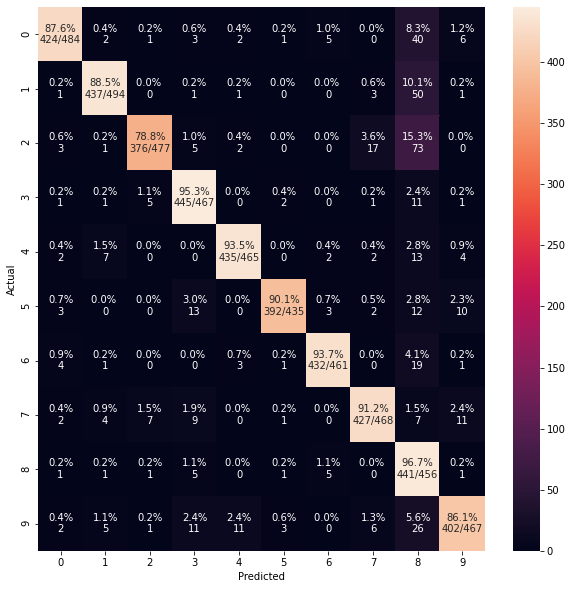

In [20]:
y_pred = gate.predict(combined_test)
y_swiss = np.array(mnist_swiss_test.targets)
y_mnist = np.array(mnist_default_test.targets)
y_true = np.concatenate((mnist_swiss_test.targets, mnist_default_test.targets))
y_true = [int(x) for x in y_true]
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])

In [52]:
gate = GatingNetwork(classes=[i for i in range(10)], experts=[swiss_model, mnist_model], name='Gate')
#gate.load_state_dict(torch.load('./trained_models/dataset_split/gate_model.pth'))
gate.fit(
    training_data=combined_train, 
    validation_data=combined_valid, 
    num_epochs=30, 
    batch_size=256, 
    criterion=criterion, 
    learning_rate=0.0001, 
    save_state_path='./trained_models/dataset_split/gate_model.pth', 
    enable_logging=False
)

------------------------------------ Beginning Training ------------------------------------
Training of  Gate
Training on device:  cuda:0
Training on 22,488 samples
Validation on 5,624 samples
Trainable parameters 1,114,754:
Total parameters 1,114,754:
Epoch 1/30
----------
training Loss: 0.0000  Accuracy: 0.9801
validation Loss: 0.0000  Accuracy: 0.9847

Epoch 2/30
----------
training Loss: 0.0000  Accuracy: 0.9860
validation Loss: 0.0000  Accuracy: 0.9858

Epoch 3/30
----------
training Loss: 0.0000  Accuracy: 0.9868
validation Loss: 0.0000  Accuracy: 0.9860

Epoch 4/30
----------
training Loss: 0.0000  Accuracy: 0.9868
validation Loss: 0.0000  Accuracy: 0.9860

Epoch 5/30
----------
training Loss: 0.0000  Accuracy: 0.9868
validation Loss: 0.0000  Accuracy: 0.9854

Epoch 6/30
----------
training Loss: 0.0000  Accuracy: 0.9870
validation Loss: 0.0000  Accuracy: 0.9858

Epoch 7/30
----------
training Loss: 0.0000  Accuracy: 0.9873
validation Loss: 0.0000  Accuracy: 0.9860

Epoch 8/30


In [29]:
print('Gate performance on mnist testset: ', gate.evaluate(mnist_default_test, 32, criterion, device))
print('Gate performance on swiss testset: ', gate.evaluate(mnist_swiss_test, 32, criterion, device))
print('Gate performance on gate testset: ', gate.evaluate(combined_test, 32, criterion, device))

Gate performance on mnist testset:  {'loss': 0.0423, 'acc': 0.9867, 'entropy': 0.0281, 'name': 'Gate'}
Gate performance on swiss testset:  {'loss': 0.0551, 'acc': 0.988, 'entropy': 0.1138, 'name': 'Gate'}
Gate performance on gate testset:  {'loss': 0.0487, 'acc': 0.9874, 'entropy': 0.071, 'name': 'Gate'}


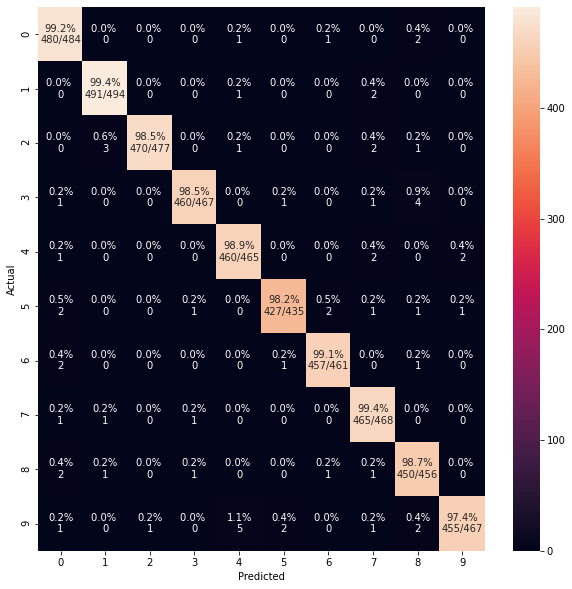

In [32]:
# trained gate performance on combined test set
y_pred = gate.predict(combined_test)
y_swiss = np.array(mnist_swiss_test.targets)
y_mnist = np.array(mnist_default_test.targets)
y_true = np.concatenate((mnist_swiss_test.targets, mnist_default_test.targets))
y_true = [int(x) for x in y_true]
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])

In [16]:
# trained gate performance on default mnist test set
y_pred = gate.predict(mnist_test, device)
y_true = np.array(mnist_test.targets)
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])

NameError: name 'mnist_test' is not defined

In [17]:
# trained gate performance on default mnist test set
y_pred = gate.predict(swiss_test, device)
y_true = np.array(swiss_test.targets)
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])

NameError: name 'swiss_test' is not defined